# Week 5 GANs

Student, University of Colorado Boulder

## Step 1 Brief description of the problem and data

The week 5 mini project is an unsupervised deep learning project.

GAN, Generative Adversarial Networkm is a concept in Deep Learning where to achieve an objective, a neural networks learns on its own.

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator, in our project, is a neural network that creates the images. For our competition, we should generate images in the style of Monet. This generator is trained using a discriminator. The discriminator — a neural network that discriminates between real/true data from fake/generated data, in out project, discriminates between images.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

I will be building a GAN that generates 7,000 to 10,000 Monet-style images.

The details are available in the Kaggle competition https://www.kaggle.com/competitions/gan-getting-started

In [2]:
import numpy as np
import pandas as pd
import os

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import GroupNormalization

## Step 2 Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the data

#### Data Extraction
User has to register on Kaggle to get access to the dataset.  The data is expected to be present in /kaggle/input/gan-getting-started/ or a similar folder ./kaggle/input/gan-getting-started/ where the notebook is running

In [4]:
data_path = '/kaggle'
if os.path.isdir('kaggle'):
    data_path = 'kaggle'

print(f'data path is {data_path}')
    
        
monet_jpg_path = os.path.join(data_path, 'input/gan-getting-started/monet_jpg/')
photo_jpg_path = os.path.join(data_path, 'input/gan-getting-started/photo_jpg/')

monet_tfrec_path = os.path.join(data_path, 'input/gan-getting-started/monet_tfrec/')
photo_tfrec_path = os.path.join(data_path, 'input/gan-getting-started/photo_tfrec/')

print(f'monet jpg path is {monet_jpg_path}, photo jpg path is {photo_jpg_path}, monet tfrec path is {monet_tfrec_path},  photo tfrec path is {photo_tfrec_path}')

data path is kaggle
monet jpg path is kaggle/input/gan-getting-started/monet_jpg/, photo jpg path is kaggle/input/gan-getting-started/photo_jpg/, monet tfrec path is kaggle/input/gan-getting-started/monet_tfrec/,  photo tfrec path is kaggle/input/gan-getting-started/photo_tfrec/


In [5]:
def get_files_in_path(path, count):
    paths = []
    c= 0
    for _, _, file_names in os.walk(path):
        for file_name in file_names:
            paths.append(os.path.join(path, file_name))
            c += 1
            if c == count:
                break
    return paths
    
def display_images(image_paths):
    figure, ax = plt.subplots(nrows=2,ncols=4,figsize=(12,8))
    for i, path in enumerate(image_paths):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[i].imshow(image)
            ax.ravel()[i].set_axis_off()
        except Exception as ex:
            print(f'exception {ex} showing image {path}')
    plt.tight_layout()
    plt.show()

Let us look at some monet images

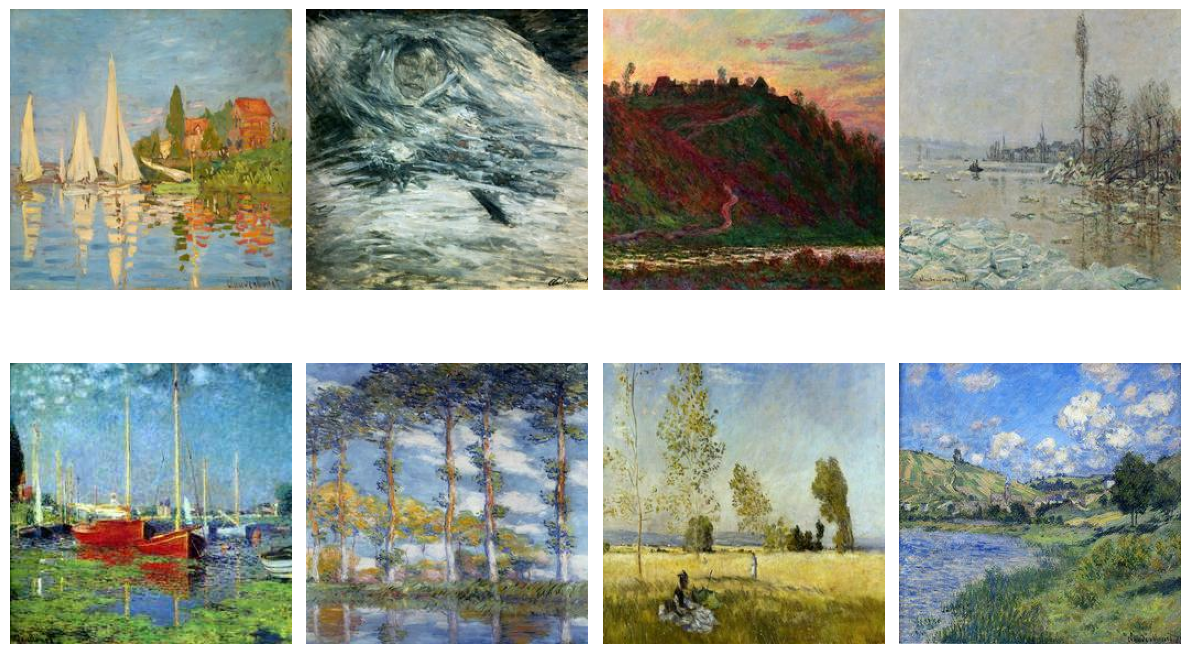

In [6]:
display_images(get_files_in_path(monet_jpg_path, 8))

Let us look at some actual images

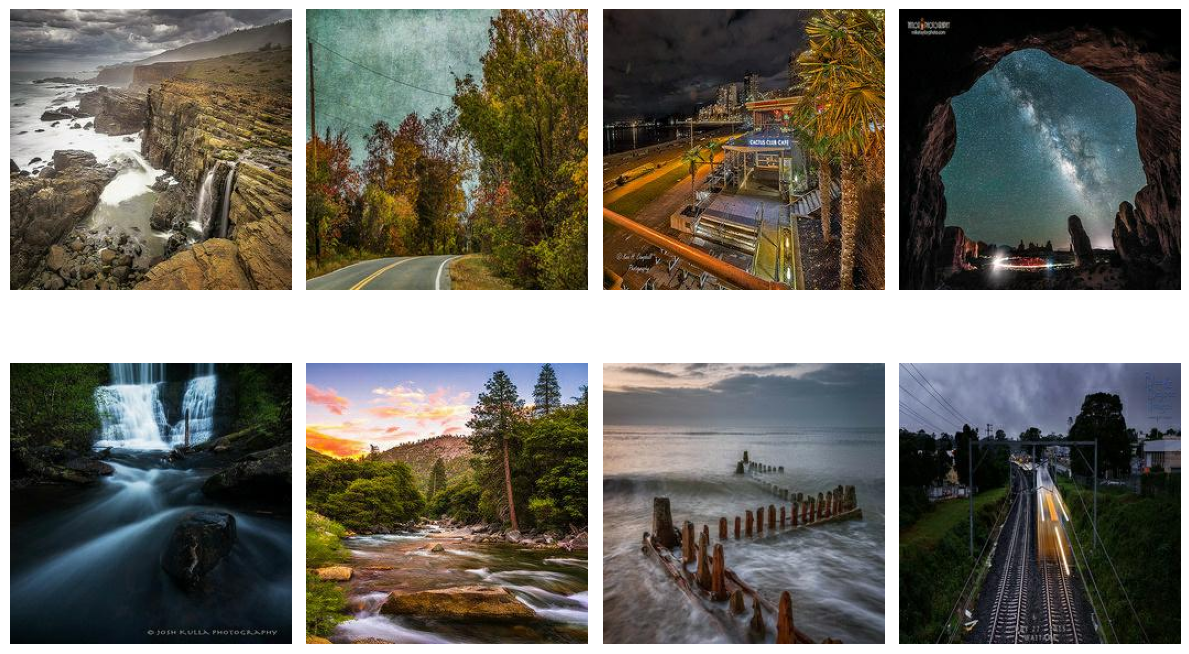

In [7]:
display_images(get_files_in_path(photo_jpg_path, 8))

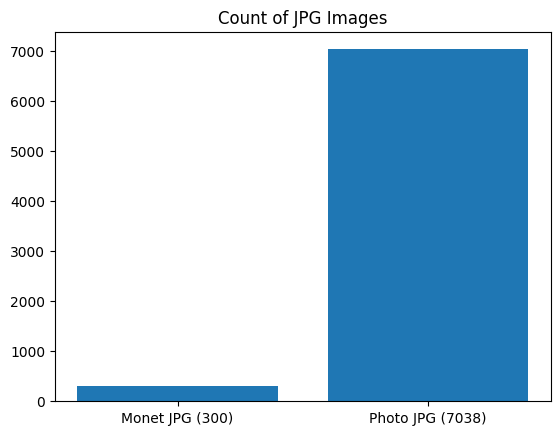

In [9]:
monet_jpg_images = get_files_in_path(monet_jpg_path, 0)
photo_jpg_images = get_files_in_path(photo_jpg_path, 0)

monet_jpg_count = len(monet_jpg_images)
photo_jpg_count = len(photo_jpg_images)

x = [f'Monet JPG ({monet_jpg_count})', f'Photo JPG ({photo_jpg_count})']
y = [monet_jpg_count, photo_jpg_count]
plt.bar(x,y)
plt.title('Count of JPG Images')
plt.show()

Check for TPU

In [10]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.16.1


## TODO check if images are all of same resolution

In [11]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [12]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

monet_tfrec_files = get_files_in_path(monet_tfrec_path, 0)
print('Monet TFRecord Files:', len(monet_tfrec_files))

photo_tfrec_files = get_files_in_path(photo_tfrec_path, 0)
print('Photo TFRecord Files:', len(photo_tfrec_files))

monet_ds = load_dataset(monet_tfrec_files, labeled=True).batch(1)
photo_ds = load_dataset(photo_tfrec_files, labeled=True).batch(1)

Monet TFRecord Files: 5
Photo TFRecord Files: 20


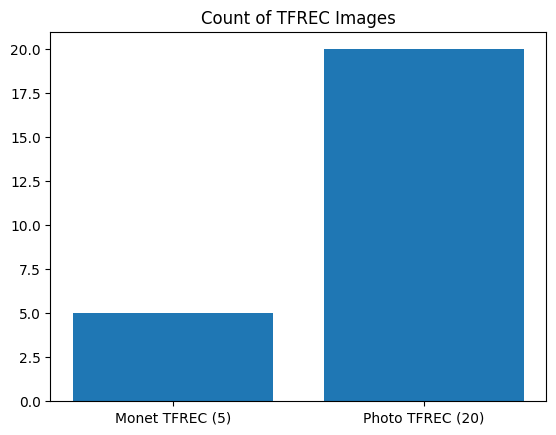

In [13]:

monet_tfrec_count = len(monet_tfrec_files)
photo_tfrec_count = len(photo_tfrec_files)

x = [f'Monet TFREC ({monet_tfrec_count})', f'Photo TFREC ({photo_tfrec_count})']
y = [monet_tfrec_count, photo_tfrec_count]
plt.bar(x,y)
plt.title('Count of TFREC Images')
plt.show()

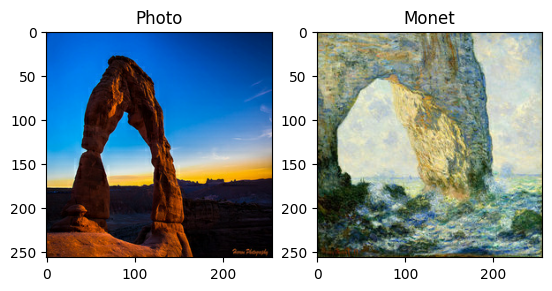

In [14]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Model building

In [21]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [22]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [23]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    return keras.Model(inputs=inputs, outputs=x)

In [24]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = GroupNormalization(groups=-1, gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [25]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

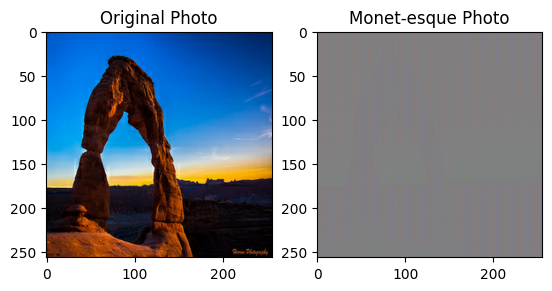

In [26]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

In [27]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [28]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [29]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [30]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [31]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [32]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [33]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [34]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - monet_disc_loss: 0.6170 - monet_gen_loss: 5.1672 - photo_disc_loss: 0.6041 - photo_gen_loss: 5.2998 - loss: 0.0000e+00
Epoch 2/25


2024-04-18 18:47:15.026877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


300/300 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - monet_disc_loss: 0.6464 - monet_gen_loss: 3.7354 - photo_disc_loss: 0.5838 - photo_gen_loss: 3.8490 - loss: 0.0000e+00
Epoch 3/25


2024-04-18 18:53:48.627529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - monet_disc_loss: 0.6428 - monet_gen_loss: 3.6487 - photo_disc_loss: 0.6105 - photo_gen_loss: 3.7701 - loss: 0.0000e+00
Epoch 4/25


2024-04-18 19:00:28.194419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - monet_disc_loss: 0.6419 - monet_gen_loss: 3.5287 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.7138 - loss: 0.0000e+00
Epoch 5/25


2024-04-18 19:07:14.887354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - monet_disc_loss: 0.6334 - monet_gen_loss: 3.3985 - photo_disc_loss: 0.5881 - photo_gen_loss: 3.5986 - loss: 0.0000e+00
Epoch 6/25


2024-04-18 19:14:04.075889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1730s 6s/step - monet_disc_loss: 0.6224 - monet_gen_loss: 3.2812 - photo_disc_loss: 0.5936 - photo_gen_loss: 3.4393 - loss: 0.0000e+00
Epoch 7/25


2024-04-18 19:42:53.999812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - monet_disc_loss: 0.6274 - monet_gen_loss: 3.2186 - photo_disc_loss: 0.5965 - photo_gen_loss: 3.3736 - loss: 0.0000e+00
Epoch 8/25


2024-04-18 19:49:24.257586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.1858 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.3055 - loss: 0.0000e+00
Epoch 9/25


2024-04-18 19:55:58.063789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.1663 - photo_disc_loss: 0.6067 - photo_gen_loss: 3.2556 - loss: 0.0000e+00
Epoch 10/25


2024-04-18 20:02:31.641371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - monet_disc_loss: 0.6035 - monet_gen_loss: 3.1454 - photo_disc_loss: 0.6083 - photo_gen_loss: 3.1945 - loss: 0.0000e+00
Epoch 11/25


2024-04-18 20:09:04.521237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 2089s 7s/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.0955 - photo_disc_loss: 0.6086 - photo_gen_loss: 3.1428 - loss: 0.0000e+00
Epoch 12/25


2024-04-18 20:43:53.404267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.0730 - photo_disc_loss: 0.6078 - photo_gen_loss: 3.1129 - loss: 0.0000e+00
Epoch 13/25


2024-04-18 20:50:42.112434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - monet_disc_loss: 0.6078 - monet_gen_loss: 3.0415 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.0866 - loss: 0.0000e+00
Epoch 14/25


2024-04-18 20:57:14.913220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - monet_disc_loss: 0.6099 - monet_gen_loss: 3.0096 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.0698 - loss: 0.0000e+00
Epoch 15/25


2024-04-18 21:03:48.482814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - monet_disc_loss: 0.6097 - monet_gen_loss: 2.9764 - photo_disc_loss: 0.5996 - photo_gen_loss: 3.0401 - loss: 0.0000e+00
Epoch 16/25


2024-04-18 21:10:21.838917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1670s 6s/step - monet_disc_loss: 0.6128 - monet_gen_loss: 2.9394 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.0128 - loss: 0.0000e+00
Epoch 17/25


2024-04-18 21:38:11.929025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - monet_disc_loss: 0.6115 - monet_gen_loss: 2.9171 - photo_disc_loss: 0.5995 - photo_gen_loss: 2.9879 - loss: 0.0000e+00
Epoch 18/25


2024-04-18 21:44:43.725529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.8909 - photo_disc_loss: 0.5931 - photo_gen_loss: 2.9827 - loss: 0.0000e+00
Epoch 19/25


2024-04-18 21:51:14.913759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.8576 - photo_disc_loss: 0.5964 - photo_gen_loss: 2.9571 - loss: 0.0000e+00
Epoch 20/25


2024-04-18 21:57:47.471308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8322 - photo_disc_loss: 0.5962 - photo_gen_loss: 2.9345 - loss: 0.0000e+00
Epoch 21/25


2024-04-18 22:04:18.444495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - monet_disc_loss: 0.6229 - monet_gen_loss: 2.7912 - photo_disc_loss: 0.5879 - photo_gen_loss: 2.9205 - loss: 0.0000e+00
Epoch 22/25


2024-04-18 22:10:48.612165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - monet_disc_loss: 0.6242 - monet_gen_loss: 2.7667 - photo_disc_loss: 0.5949 - photo_gen_loss: 2.8927 - loss: 0.0000e+00
Epoch 23/25


2024-04-18 22:17:19.449873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 1861s 6s/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.7429 - photo_disc_loss: 0.5949 - photo_gen_loss: 2.8616 - loss: 0.0000e+00
Epoch 24/25


2024-04-18 22:48:20.405141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - monet_disc_loss: 0.6296 - monet_gen_loss: 2.7061 - photo_disc_loss: 0.5954 - photo_gen_loss: 2.8255 - loss: 0.0000e+00
Epoch 25/25


2024-04-18 22:56:44.499058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - monet_disc_loss: 0.6272 - monet_gen_loss: 2.7120 - photo_disc_loss: 0.5918 - photo_gen_loss: 2.8146 - loss: 0.0000e+00


2024-04-18 23:03:16.630615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-04-18 23:17:11.368392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


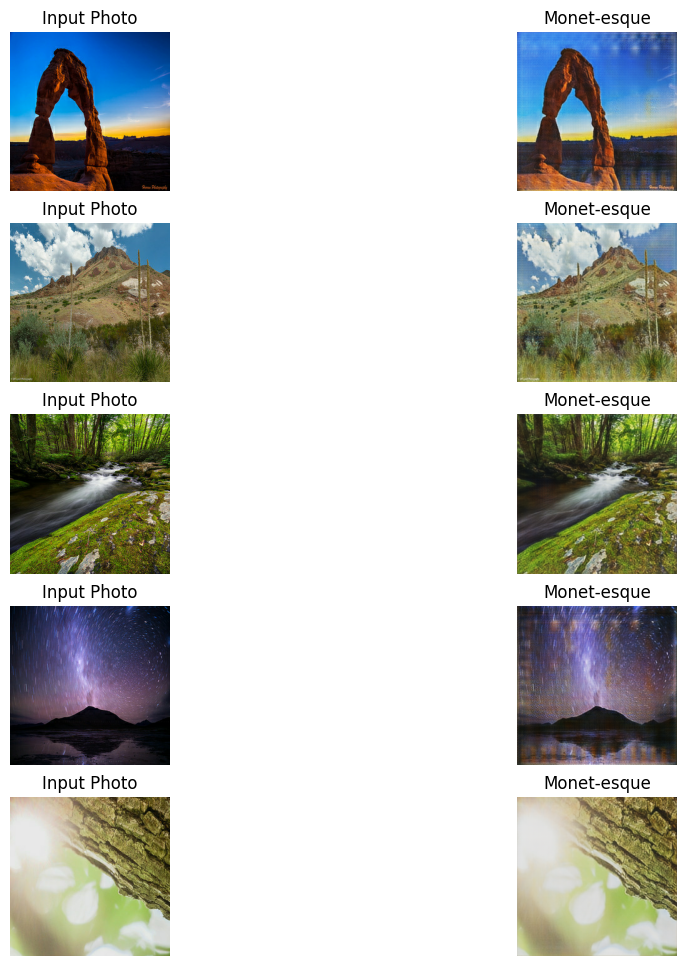

In [35]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [38]:
import PIL
import shutil

def generate_write_and_archive_images(directory_name):
    path = os.path.join(data_path, directory_name)
    os.mkdir(path) 

    i = 1
    for img in photo_ds:
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save(os.path.join(path, str(i) + ".jpg"))
        i += 1
        if i%100 == 0:
            print(f'generated {i} files')
    print(f'creating zip')
    shutil.make_archive(path,
                    'zip',
                    data_path,
                    directory_name)

generate_write_and_archive_images('default_gan')

generated 100 files
generated 200 files
generated 300 files
generated 400 files
generated 500 files
generated 600 files
generated 700 files
generated 800 files
generated 900 files
generated 1000 files
generated 1100 files
generated 1200 files
generated 1300 files
generated 1400 files
generated 1500 files
generated 1600 files
generated 1700 files
generated 1800 files
generated 1900 files
generated 2000 files
generated 2100 files
generated 2200 files
generated 2300 files
generated 2400 files
generated 2500 files
generated 2600 files
generated 2700 files
generated 2800 files
generated 2900 files
generated 3000 files
generated 3100 files
generated 3200 files
generated 3300 files
generated 3400 files
generated 3500 files
generated 3600 files
generated 3700 files
generated 3800 files
generated 3900 files
generated 4000 files
generated 4100 files
generated 4200 files
generated 4300 files
generated 4400 files
generated 4500 files
generated 4600 files
generated 4700 files
generated 4800 files
g

2024-04-19 09:58:58.228568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


creating zip
